In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import cv2

from scipy.ndimage.morphology import binary_erosion

In [4]:
def minimizePatternByTemplMatch(pattern):
    height = pattern.shape[0]
    width = pattern.shape[1]
    
    left   = pattern[:, :width/2]
    right  = pattern[:, width/2:]
    top    = pattern[:height/2]
    bottom = pattern[height/2:]
    
    #search left on right
    result = cv2.matchTemplate(right, left[:, :left.shape[1]/3], cv2.TM_CCORR_NORMED)
    maxLoc = cv2.minMaxLoc(result)[3]
    max_x = maxLoc[0] + width/2 - left.shape[1]/3/2
    plt.imshow(result)
    
    #search top on bottom
    result = cv2.matchTemplate(bottom, top[:top.shape[0]/3, :], cv2.TM_CCORR_NORMED)
    maxLoc = cv2.minMaxLoc(result)[3]
    max_y = maxLoc[1] + height/2 - top.shape[0]/3/2
    
    return pattern[:max_y, :max_x]

def readGraph(wdir, shirt_num):
    wdir = wdir + str(shirt_num) + '_result/'
    v_x = np.loadtxt(wdir+'pts_x.csv', delimiter=',') - 100 - 1
    v_y = np.loadtxt(wdir+'pts_y.csv', delimiter=',') - 100 - 1
    is_good = np.loadtxt(wdir+'is_good.csv', dtype='bool', delimiter=',')
    return [v_x, v_y, is_good]

def drawGrid(v_x, v_y, is_good):
    for i, row in enumerate(v_x):
        for j, elem in enumerate(v_x[i]):
            if (i < v_x.shape[0] - 1):
                if (is_good[i, j] and is_good[i+1, j]):
                    plt.plot([v_x[i, j], v_x[i+1, j]],
                             [v_y[i, j], v_y[i+1, j]],
                             'r', linewidth=5)

            if (j < v_x.shape[1] - 1):
                if (is_good[i, j] and is_good[i, j+1]):
                    plt.plot([v_x[i, j], v_x[i, j+1]],
                             [v_y[i, j], v_y[i, j+1]],
                             'r', linewidth=5)

def readIdx(wdir):
    fname = wdir + 'idx.txt'
    with open(fname) as f:
        shirt_nums = f.readlines()
    shirt_nums = [x.strip() for x in shirt_nums]
    return shirt_nums

In [63]:
shirt_nums

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28']

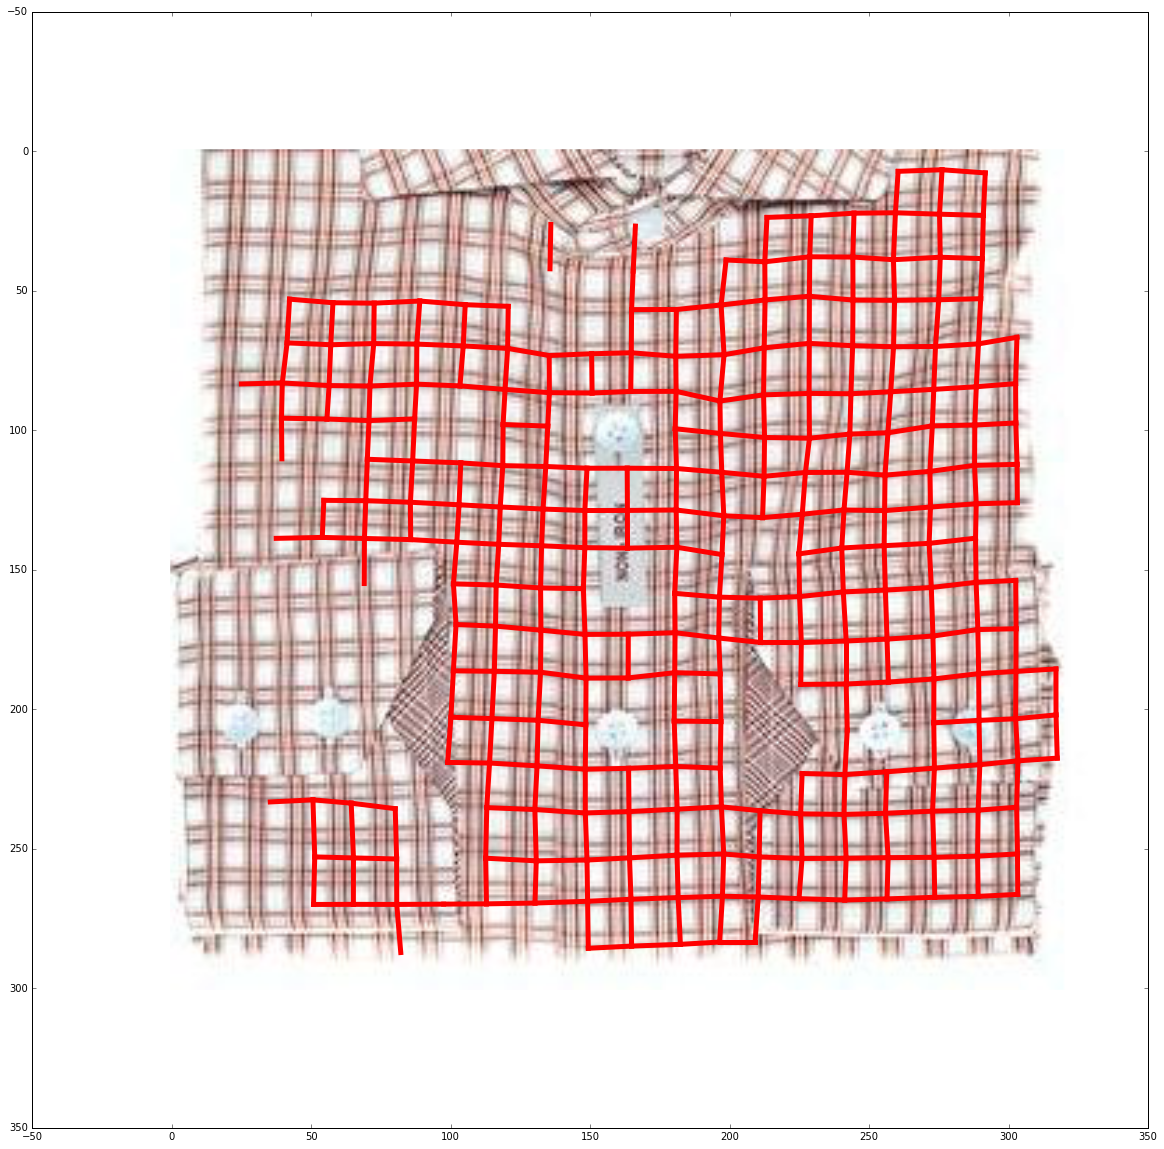

In [66]:
wdir = '../../data/data04_for_test1_results_v1/txt02_pxy_M/cropped_and_results/'
shirt_nums = readIdx(wdir)
i = 21;
shirt_path = wdir + str(shirt_nums[i]) + '.jpg'
shirt = cv2.imread(shirt_path)
plt.figure(figsize=(20, 20))
plt.imshow(shirt)

[v_x, v_y, is_good] = readGraph(wdir, shirt_nums[i])
for i, row in enumerate(v_x):
    for j, elem in enumerate(v_x[i]):
        if (i < v_x.shape[0] - 1):
            if (is_good[i, j] and is_good[i+1, j]):
                plt.plot([v_x[i, j], v_x[i+1, j]],
                         [v_y[i, j], v_y[i+1, j]],
                         'r', linewidth=5)
        
        if (j < v_x.shape[1] - 1):
            if (is_good[i, j] and is_good[i, j+1]):
                plt.plot([v_x[i, j], v_x[i, j+1]],
                         [v_y[i, j], v_y[i, j+1]],
                         'r', linewidth=5)
                
        

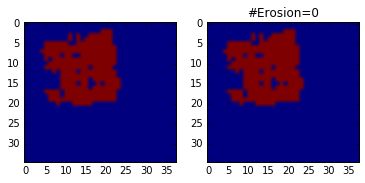

In [72]:
# extract maximal rectangle (erosion for now) 
# connected is good
blob_is_good = is_good.copy()
cntErosion=0
while np.sum(blob_is_good) > max(1.4*np.sum(is_good), 10):
    blob_is_good = binary_erosion(blob_is_good)
    cntErosion+=1
    
plt.subplot(1,2,1), plt.imshow(is_good)
plt.subplot(1,2,2), plt.imshow(blob_is_good)
plt.title('#Erosion=%d' % (cntErosion) )

In [73]:
#Gathering vectors tx and ty
tx = []
ty = []

for i, row in enumerate(v_x):
    for j, elem in enumerate(v_x[i]):
        if (j < v_x.shape[1] - 1):
            if (blob_is_good[i, j] and blob_is_good[i, j+1]):
                tx.append([v_x[i, j+1] - v_x[i, j], v_y[i, j+1] - v_y[i, j]])
                
        if (i < v_x.shape[0] - 1):
            if (blob_is_good[i, j] and blob_is_good[i+1, j]):
                ty.append([v_x[i+1, j] - v_x[i, j], v_y[i+1, j] - v_y[i, j]])
                
tx = np.array(tx) # [x, y]
ty = np.array(ty) # [x, y]

#Acquiring average
tx_avg = np.average(tx, axis=0)
ty_avg = np.average(ty, axis=0)
print('tx average', tx_avg)
print('ty average', ty_avg)

tx average [ 15.56364865  -0.07216216]
ty average [ -0.2181982   15.28707207]


In [14]:
blob_good_idx.shape

NameError: name 'blob_good_idx' is not defined

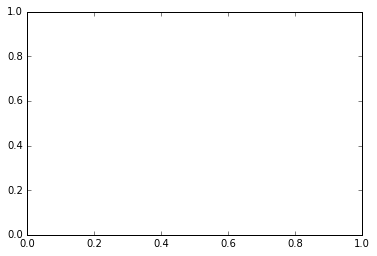

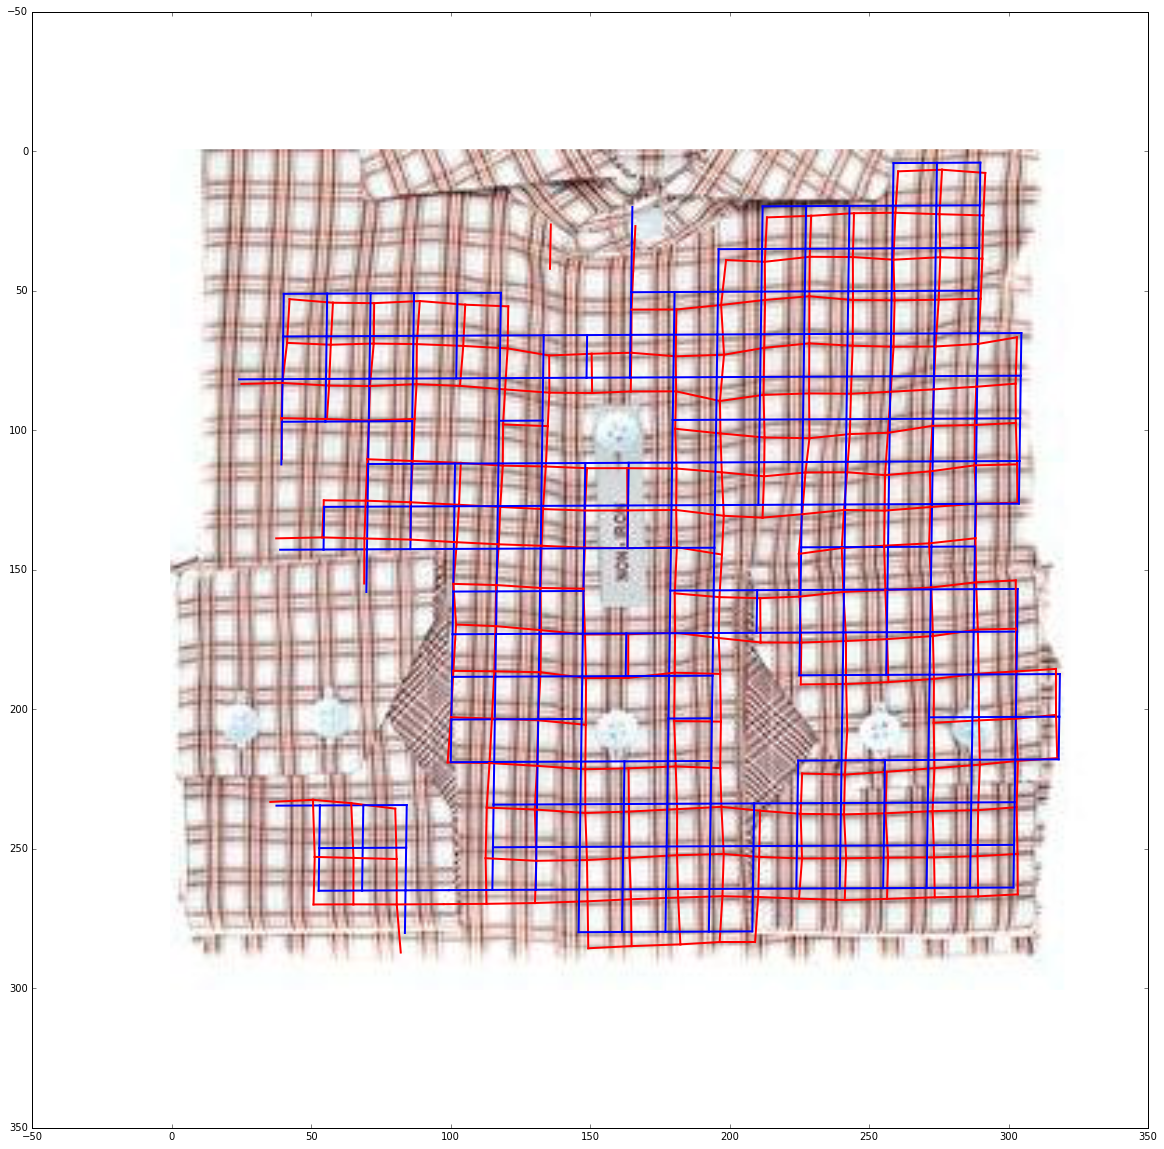

In [74]:
#Grid alignment
import queue #we need bfs, because it is connceted blob

#v_x, v_y - is real, input
# create regular, output
reg_v_x = np.empty_like(v_x)
reg_v_x.fill(-1)
reg_v_y = np.empty_like(v_y)
reg_v_y.fill(-1)

que = queue.Queue()

blob_good_idx = np.transpose(np.where(blob_is_good))
start = blob_good_idx[blob_good_idx.shape[0]//2 - 1]

reg_v_x[start[0], start[1]] = v_x[start[0], start[1]]
reg_v_y[start[0], start[1]] = v_y[start[0], start[1]]
que.put(start)

while not que.empty():
    [i, j] = que.get()
    
    if (i > 0 and reg_v_x[i-1, j] == -1 and blob_is_good[i-1, j]): # -ty, because i-1
        reg_v_x[i-1, j] = reg_v_x[i, j] - ty_avg[0] 
        reg_v_y[i-1, j] = reg_v_y[i, j] - ty_avg[1]
        que.put([i-1, j])
    if (i < blob_is_good.shape[0] - 1 and reg_v_x[i+1, j] == -1 and blob_is_good[i+1, j]): # +ty, because i+1
        reg_v_x[i+1, j] = reg_v_x[i, j] + ty_avg[0] 
        reg_v_y[i+1, j] = reg_v_y[i, j] + ty_avg[1]
        que.put([i+1, j])
    if (j > 0 and reg_v_x[i, j-1] == -1 and blob_is_good[i, j-1]): # -tx, because j-1
        reg_v_x[i, j-1] = reg_v_x[i, j] - tx_avg[0]
        reg_v_y[i, j-1] = reg_v_y[i, j] - tx_avg[1]
        que.put([i, j-1])
    if (j < blob_is_good.shape[1] - 1 and reg_v_x[i, j+1] == -1 and blob_is_good[i, j+1]): # +tx, because j+1
        reg_v_x[i, j+1] = reg_v_x[i, j] + tx_avg[0]
        reg_v_y[i, j+1] = reg_v_y[i, j] + tx_avg[1]
        que.put([i, j+1])
        
# plot regular result
plt.hold(True)
plt.figure(figsize=(20, 20))
plt.imshow(shirt)
for i, row in enumerate(v_x):
    for j, elem in enumerate(v_x[i]):
        if (i < v_x.shape[0] - 1):
            if (blob_is_good[i, j] and blob_is_good[i+1, j]):
                plt.plot([v_x[i, j], v_x[i+1, j]],
                         [v_y[i, j], v_y[i+1, j]],
                         'r', linewidth=2)
                plt.plot([reg_v_x[i, j], reg_v_x[i+1, j]],
                         [reg_v_y[i, j], reg_v_y[i+1, j]],
                         'b', linewidth=2)
        
        if (j < v_x.shape[1] - 1):
            if (blob_is_good[i, j] and blob_is_good[i, j+1]):
                plt.plot([v_x[i, j], v_x[i, j+1]],
                         [v_y[i, j], v_y[i, j+1]],
                         'r', linewidth=2)
                plt.plot([reg_v_x[i, j], reg_v_x[i, j+1]],
                         [reg_v_y[i, j], reg_v_y[i, j+1]],
                         'b', linewidth=2)

[[ 136.   68.]
 [ 281.  245.]]


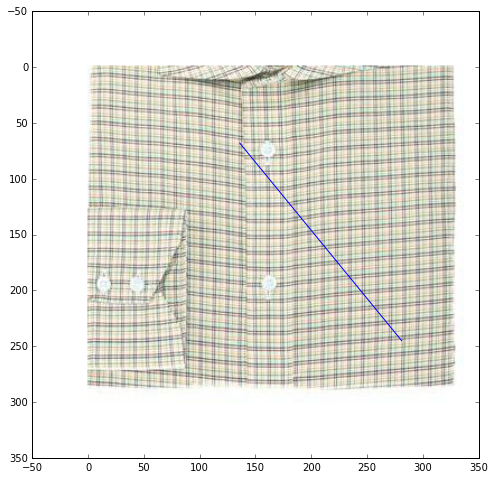

In [31]:
# Calculating BBox for grid
X = v_x[blob_is_good]
Y = v_y[blob_is_good]
    
min_x = min(X)
max_x = max(X)
min_y = min(Y)
max_y = max(Y)
bbox = np.array([[min_x, min_y], [max_x, max_y]])
bbox = np.round(bbox)
print(bbox)
plt.figure(figsize=(8, 8))
plt.hold(True)
plt.imshow(shirt)
plt.plot(bbox[:, 0], bbox[:, 1])
plt.hold(False)

In [24]:
# interpolate dx\dy for pixels
from scipy.interpolate import griddata

real_pts = []
regular_pts = []
dx = []
dy = []
for i, j in blob_good_idx:
    real_pts.append( [v_x[i, j], v_y[i, j]] )
    regular_pts += [ reg_v_x[i, j], reg_v_y[i, j] ]
    dx += [ reg_v_x[i, j] - v_x[i, j] ]
    dy += [ reg_v_y[i, j] - v_y[i, j] ]
    
real_pts = np.array(real_pts)
regular_pts = np.array(regular_pts)
dx = np.array(dx)
dy = np.array(dy)

# unknown_pts = []
# for i in range(bbox[0, 1], bbox[1, 1] + 1):
#     for j in range(bbox[0, 0], bbox[1, 0] + 1):
#         unknown_pts += [ [i, j] ]
bbox = bbox.astype(np.int)
grid_x, grid_y = np.mgrid[bbox[0, 0]:bbox[1, 0] + 1, bbox[0, 1]:bbox[1, 1] + 1]
        
# .T, because x, y and i, j
values_x = griddata(real_pts, dx, (grid_x, grid_y), method='linear').T
values_y = griddata(real_pts, dy, (grid_x, grid_y), method='linear').T
blob = shirt[bbox[0, 1]:bbox[1, 1] + 1, bbox[0, 0]:bbox[1, 0] + 1]

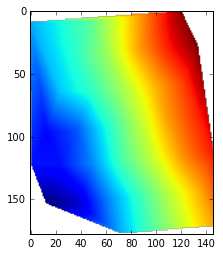

In [47]:
plt.imshow(values_y)

(31, 43, 3)


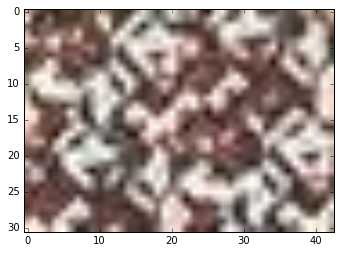

In [6]:
bbox = bbox.astype(np.int)
pattern = shirt[bbox[0,0]:bbox[1,0], bbox[0,1]:bbox[1,1]]
print(pattern.shape)
plt.imshow(pattern)

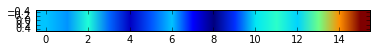

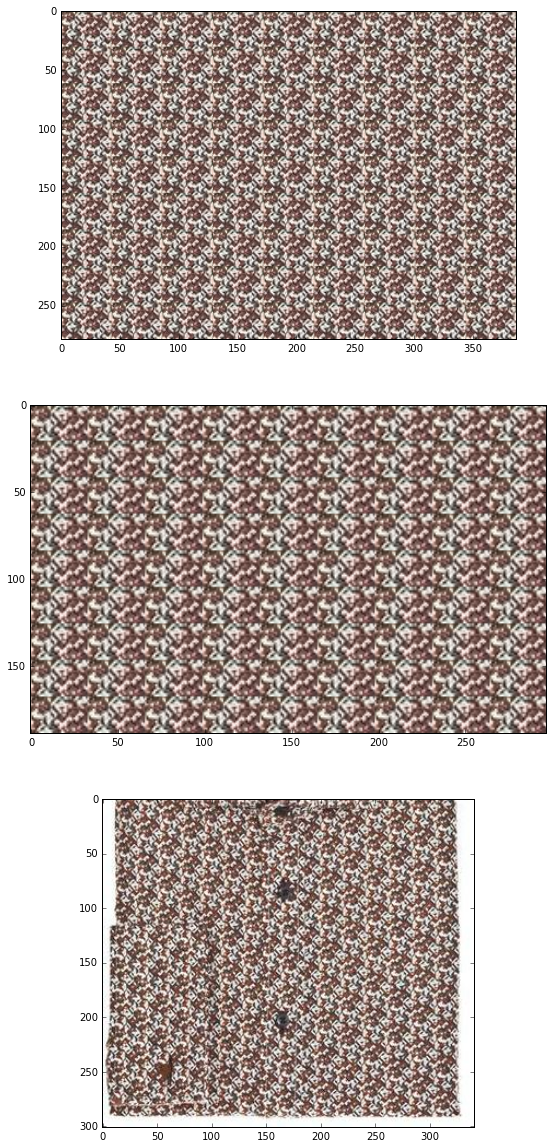

In [11]:
min_pattern = MinimizePatternByTemplMatch(pattern)
tiled = np.tile(min_pattern, (9, 9, 1))
stupid = np.tile(pattern, (9, 9, 1))

plt.figure(figsize=(20,20))
plt.subplot(3, 1, 1)
plt.imshow(stupid)
plt.subplot(3, 1, 2)
plt.imshow(tiled)
plt.subplot(3, 1, 3)
plt.imshow(shirt)

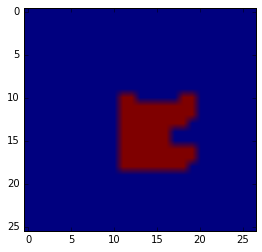

In [23]:
plt.imshow(is_good)

In [100]:
np.transpose((grid_x, grid_y))

array([[[137,  75],
        [138,  75],
        [139,  75],
        ..., 
        [281,  75],
        [282,  75],
        [283,  75]],

       [[137,  76],
        [138,  76],
        [139,  76],
        ..., 
        [281,  76],
        [282,  76],
        [283,  76]],

       [[137,  77],
        [138,  77],
        [139,  77],
        ..., 
        [281,  77],
        [282,  77],
        [283,  77]],

       ..., 
       [[137, 246],
        [138, 246],
        [139, 246],
        ..., 
        [281, 246],
        [282, 246],
        [283, 246]],

       [[137, 247],
        [138, 247],
        [139, 247],
        ..., 
        [281, 247],
        [282, 247],
        [283, 247]],

       [[137, 248],
        [138, 248],
        [139, 248],
        ..., 
        [281, 248],
        [282, 248],
        [283, 248]]])

In [92]:
grid_y

array([[ 75,  76,  77, ..., 246, 247, 248],
       [ 75,  76,  77, ..., 246, 247, 248],
       [ 75,  76,  77, ..., 246, 247, 248],
       ..., 
       [ 75,  76,  77, ..., 246, 247, 248],
       [ 75,  76,  77, ..., 246, 247, 248],
       [ 75,  76,  77, ..., 246, 247, 248]])

In [93]:
bbox

array([[137,  75],
       [283, 248]])

In [113]:
grid_x.shape

(147, 174)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [118]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

from scipy.interpolate import griddata
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

grid_x.shape

(100, 200)

In [121]:
grid_y.shape

(100, 200)

In [30]:
v_x[blob_is_good]


array([ 255.64,  183.6 ,  158.33,  135.86,  268.87,  243.82,  220.58,
        196.98,  171.77,  256.78,  233.85,  208.8 ,  185.42,  159.85,
        269.98,  244.79,  220.82,  197.85,  171.93,  148.47,  281.42,
        256.81,  233.33,  207.98,  185.45,  160.11,  136.15,  269.14,
        244.02,  220.35,  197.1 ,  172.34,  148.4 ,  281.19,  255.85,
        232.4 ,  207.74])

In [33]:
dx

array([ 2.52144089,  1.86419951,  2.90178571,  1.13937192,  1.49751232,
        2.31509852,  1.32268473,  0.69027094,  1.66785714,  1.56116995,
        0.25875616,  1.07634236,  0.22392857,  1.56151478,  0.56724138,
        1.52482759,  1.26241379,  0.        ,  1.68758621,  0.91517241,
        1.33331281,  1.71089901,  0.95848522,  2.07607143,  0.37365764,
        1.48124384,  1.20883005,  1.58697044,  2.47455665,  1.91214286,
        0.92972906,  1.45731527,  1.16490148,  1.74304187,  2.85062808,
        2.06821429,  2.49580049])

In [38]:
pts1 = np.transpose((v_x[blob_is_good], v_y[blob_is_good]))
pts2 = np.transpose((reg_v_x[blob_is_good], reg_v_y[blob_is_good]))
reg_v_x[blob_is_good] - v_x[blob_is_good] == dx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [43]:
values_x.shape

(178, 146)